In [72]:
import numpy as np
import librosa
import pandas as pd
import soundfile as sf
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm
from joblib import Parallel, delayed

In [57]:
train = pd.read_csv("../birdclef-2022-data/train_metadata.csv")

In [97]:
SEED = 42
AUDIO_PATH = '../birdclef-2022-data/train_audio'
IMAGE_PATH = '../birdclef-2022-data/train_images/'
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])
NUM_WORKERS = 4
CLASSES = sorted(os.listdir(AUDIO_PATH))
NUM_CLASSES = len(CLASSES)

class AudioParams:
    """
    Parameters used for the audio data
    """
    sr = 32000
    duration = 5
    length = sr * duration
    # Melspectrogram
    n_mels = 224
    fmin = 20
    fmax = 16000

In [59]:
def crop_or_pad(y):
    """
    Crops an array to a chosen length
    Arguments:
        y {1D np array} -- Array to crop
        length {int} -- Length of the crop
        sr {int} -- Sampling rate
    Keyword Arguments:
        train {bool} -- Whether we are at train time. If so, crop randomly, else return the beginning of y (default: {True})
        probs {None or numpy array} -- Probabilities to use to chose where to crop (default: {None})
    Returns:
        1D np array -- Cropped array
    """
    start = 0
    length = len(y)
    z = []
    for _ in range(math.ceil(len(y) / AudioParams.length)):
        if length <= AudioParams.length:
            z.append(np.concatenate([y[start:], np.zeros(AudioParams.length - length)]).astype(np.float32))
        else:
            z.append(y[start: start + AudioParams.length].astype(np.float32))
            length -= AudioParams.length
            start += AudioParams.length

    return z

In [60]:


def compute_melspec(y, params):
    """
    Computes a mel-spectrogram and puts it at decibel scale
    Arguments:
        y {np array} -- signal
        params {AudioParams} -- Parameters to use for the spectrogram. Expected to have the attributes sr, n_mels, f_min, f_max
    Returns:
        np array -- Mel-spectrogram
    """
    melspec = librosa.feature.melspectrogram(
        y=y, sr=params.sr, n_mels=params.n_mels, fmin=params.fmin, fmax=params.fmax,
    )

    melspec = librosa.power_to_db(melspec).astype(np.float32)
    return melspec

In [61]:
def mono_to_color(X, eps=1e-6, mean=None, std=None):
    """
    Converts a one channel array to a 3 channel one in [0, 255]
    Arguments:
        X {numpy array [H x W]} -- 2D array to convert
    Keyword Arguments:
        eps {float} -- To avoid dividing by 0 (default: {1e-6})
        mean {None or np array} -- Mean for normalization (default: {None})
        std {None or np array} -- Std for normalization (default: {None})
    Returns:
        numpy array [3 x H x W] -- RGB numpy array
    """
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)

    # Normalize to [0, 255]
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V

11.10203125


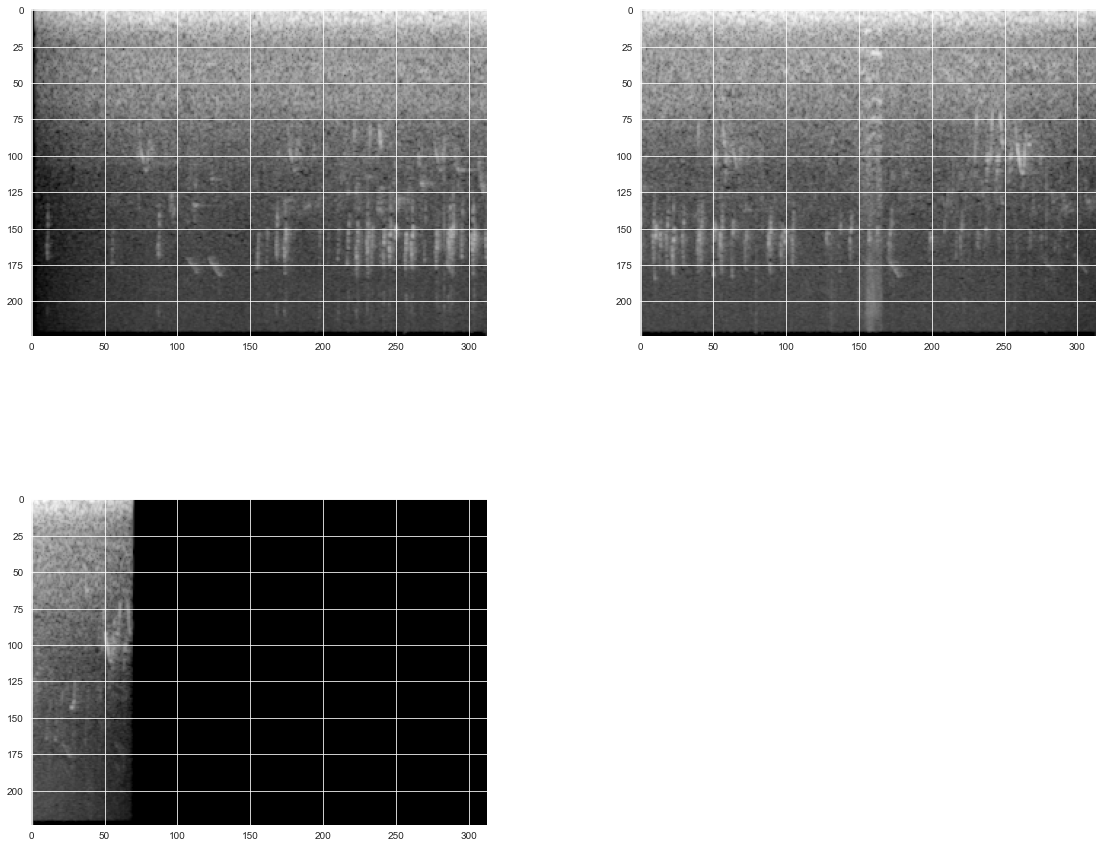

In [62]:
# 5 sec cropped
audio_name = '../birdclef-2022-data/train_audio/afrsil1/XC125458.ogg'

#path = train['file_path'][0]
y, sr = sf.read(audio_name, always_2d=True)
print(len(y)/sr)
y = np.mean(y, 1)
y = crop_or_pad(y)

plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.5)

for index, element in enumerate(y):
    ax = plt.subplot(2, 2, index + 1)
    X = compute_melspec(element, AudioParams)
    X = mono_to_color(X)
    X = X.astype(np.uint8)
    plt.imshow(X)
plt.show()


In [99]:
def Audio_to_Images(path, save_path, params):
    y, sr = sf.read(path, always_2d=True)
    y = np.mean(y, 1) # there is (X, 2) array
    y = crop_or_pad(y)
    for index, img in enumerate(y):
        image = compute_melspec(img, params)
        image = mono_to_color(image)
        image = image.astype(np.uint8)
        np.save(save_path + f"_{index}", image)

def save_(path):
    save_path = IMAGE_PATH + "/".join(path.split('/')[-2:])
    save_path = save_path[:-4]
    Audio_to_Images(path, save_path, AudioParams)

['../birdclef-2022-data/train_audio/afrsil1/XC125458.ogg'
 '../birdclef-2022-data/train_audio/afrsil1/XC175522.ogg'
 '../birdclef-2022-data/train_audio/afrsil1/XC177993.ogg' ...
 '../birdclef-2022-data/train_audio/zebdov/XC665873.ogg'
 '../birdclef-2022-data/train_audio/zebdov/XC666194.ogg'
 '../birdclef-2022-data/train_audio/zebdov/XC666195.ogg']


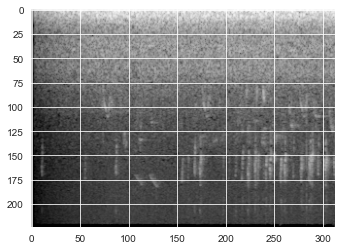

In [103]:
paths = AUDIO_PATH + '/' + train['filename']
paths = paths.values
print(paths)
save_(paths[0])

path_name = '../birdclef-2022-data/train_images/afrsil1/XC125458_0.npy'
spec = np.load(path_name)
plt.imshow(spec)

In [104]:
def save_and_generate_specs():
    NUM_WORKERS = 4
    _ = Parallel(n_jobs=NUM_WORKERS)(delayed(save_)(AUDIO_PATH) for AUDIO_PATH in tqdm(paths))


  1%|          | 156/14852 [00:26<37:06,  6.60it/s] 

KeyboardInterrupt: 